In [45]:
from typing import Callable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF

In [132]:
def dot(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return a[:, 0] * b[:, 0] + a[:, 1] * b[:, 1] + a[:, 2] * b[:, 2]

def length(x: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(dot(x, x))

def normalize(x: torch.Tensor) -> torch.Tensor:
    return x / length(x).reshape(-1, 1)

def sdf_sphere(pos: torch.Tensor, radius: float = 1.) -> torch.Tensor:
    return torch.sqrt(dot(pos, pos)) - radius #+ torch.sin(pos[:, 0] * 10.) * .1

def sdf_plane(pos: torch.Tensor, norm: torch.Tensor, offset: float = 0.) -> torch.Tensor:
    if norm.ndim != 2:
        norm = norm.reshape(1, 3).expand(pos.shape[0], -1)
    return dot(pos, norm) - offset

def sdf_plane_y(pos: torch.Tensor, offset: float = 0.) -> torch.Tensor:
    return pos[:, 1] - offset
    #return normalize(pos)[:, 1]

#sdf_sphere(torch.Tensor([[.5,.5,0], [1,0,0]]))
#sdf_plane_y(torch.Tensor([[.5,.5,0], [-1,0,0]]))
#sdf_plane(torch.Tensor([[.5,.5,0], [1,0,0]]), torch.Tensor([1, 0, 0]), 0)
#length(torch.Tensor([[.5,.5,0], [1,0,0]]))
#torch.minimum(torch.Tensor([[1, 2], [3, 4]]), torch.Tensor([[5, 2], [3, 3]]))

tensor([0.5000, 1.0000])

In [117]:
def sdf_scene(pos: torch.Tensor) -> torch.Tensor:
    d = sdf_sphere(pos)
    d = torch.minimum(d, sdf_plane_y(pos))
    #d = sdf_plane_y(pos)
    return d

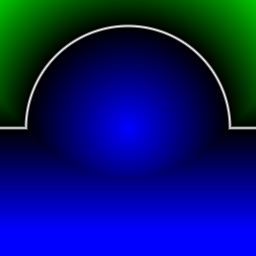

In [144]:
def get_pos_grid(size: int = 256, space: float = 1.25, z: float = 0., flat: bool = False):
    grid = torch.linspace(-space, space, size).reshape(size, 1).expand(size, -1, 3).clone()
    grid[:,:,1] = torch.linspace(space, -space, size).reshape(size, 1).expand(-1, size)
    grid[:,:,2] = z
    if flat:
        grid = grid.reshape(size * size, 3)
    return grid

def render_sdf_grid(sdf: Callable, size: int = 256, space: float = 1.25, z: float = 0., edge_width: float = 0.02):
    grid = get_pos_grid(size=size, space=space, z=z)
    
    dist = sdf(grid.reshape(size*size, 3)).reshape(size, size)
    rgb = torch.clamp(1.-torch.abs(dist) / edge_width, 0, 1).repeat(3, 1, 1)
    rgb[1,:,:] += torch.clamp(dist / 1., 0, 1)
    rgb[2,:,:] += torch.clamp(dist / -1., 0, 1)
    return VF.to_pil_image(rgb)

render_sdf_grid(sdf_scene)

casts: 3439326


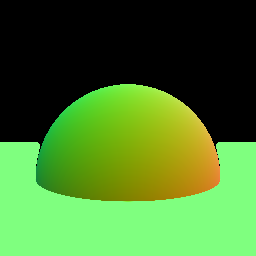

In [196]:
def get_sdf_normal(sdf: Callable, pos: torch.Tensor) -> torch.Tensor:
    e = 0.001
    return normalize(torch.cat([
        (sdf(pos + torch.Tensor([e, 0, 0])) - sdf(pos - torch.Tensor([e, 0, 0]))).reshape(-1, 1),
        (sdf(pos + torch.Tensor([0, e, 0])) - sdf(pos - torch.Tensor([0, e, 0]))).reshape(-1, 1),
        (sdf(pos + torch.Tensor([0, 0, e])) - sdf(pos - torch.Tensor([0, 0, e]))).reshape(-1, 1),
    ], dim=-1))

#get_sdf_normal(sdf_scene, torch.Tensor([[1, 0, 0], [0, 1, 0]]))

def raymarch(sdf: Callable, pos: torch.Tensor, size: int = 256, as_pil: bool = False):
    ray_pos = get_pos_grid(size=size, space=0.2, flat=True) + pos
    ray_dir = normalize(get_pos_grid(size=size, space=1., z=1.5, flat=True))
    indices = torch.Tensor(list(range(size * size))).type(torch.long)
    color_buffer = torch.zeros(size * size, 3)
    
    num_ray_casts = 0
    for i in range(100):
        dist = sdf(ray_pos)
        num_ray_casts += ray_pos.shape[0]
        
        # check for surface
        is_surface = torch.abs(dist) < .001
        
        if torch.any(is_surface):
            normals = get_sdf_normal(sdf, ray_pos[is_surface])

            # assign colors to color buffer
            color_buffer[indices[is_surface]] = normals * .5 + .5#torch.Tensor([1, 1, 1])

        # remove all rays that hit surface
        keep_ray = ~is_surface
        indices = indices[keep_ray]
        dist = dist[keep_ray]
        ray_pos = ray_pos[keep_ray]
        ray_dir = ray_dir[keep_ray]
                
        # forward rays
        ray_pos = ray_pos + ray_dir * dist.reshape(-1, 1)
    
    print("casts:", num_ray_casts)
    color_buffer = color_buffer.reshape(size, size, 3)
    if as_pil:
        return VF.to_pil_image(color_buffer.permute(2, 0, 1))
    return color_buffer

raymarch(sdf_scene, torch.Tensor([0, .5, -2.]), size=256, as_pil=True)

In [198]:

torch.count_nonzero(torch.Tensor([True, True, False]))

tensor(2)